#Upload libraries

In [2]:
import numpy as np
import pandas as pd
import os
!pip install opendatasets
import opendatasets as od
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image


import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image

#Upload Model

In [3]:
from keras.models import load_model
best_model = load_model('/content/bestModel.h5')

#Validation test

Loading dataset used to train the network

username:micaelacabrera
key:bd2254ab58398111a17656e8bf98b5ad

In [ ]:
dataset_link="https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset/data"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: micaelacabrera
Your Kaggle Key: ··········


100%|██████████| 161M/161M [00:03<00:00, 48.9MB/s]


In [ ]:
from PIL import Image
X = []
Y = []

for i in tqdm(glob('/content/drowsiness-dataset/train/Open/*')):
    img=Image.open(i)
    imgGray = img.convert("L")
    temp = np.array(imgGray.resize((64,64)))
    X.append(temp)
    Y.append(1)

for i in tqdm(glob('/content/drowsiness-dataset/train/Closed/*')):
    img=Image.open(i)
    imgGray = img.convert("L")
    temp = np.array(imgGray.resize((64,64)))
    X.append(temp)
    Y.append(0)

100%|██████████| 726/726 [00:01<00:00, 379.05it/s]


In [ ]:
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

In [ ]:
X = np.expand_dims(X,-1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

Testing images

1/1 [==============================] - 1s 1s/step


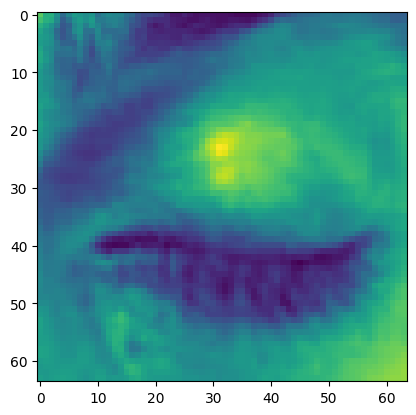

Closed
1/1 [==============================] - 0s 107ms/step


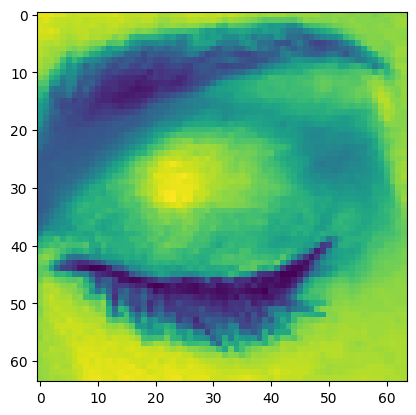

Closed
1/1 [==============================] - 0s 131ms/step


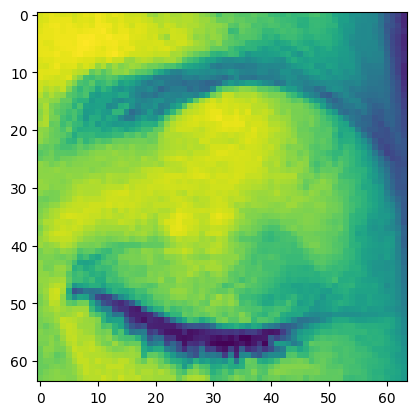

Closed
1/1 [==============================] - 0s 49ms/step


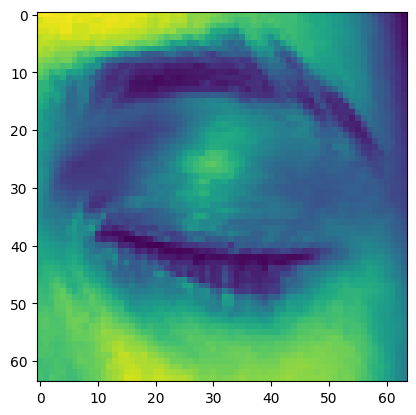

Closed
1/1 [==============================] - 0s 27ms/step


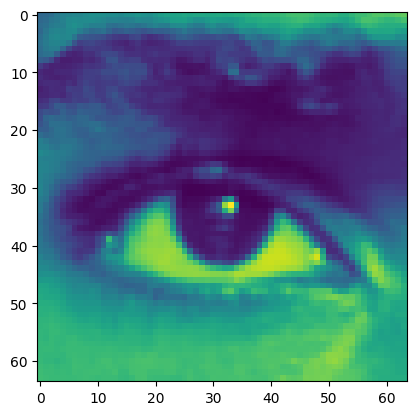

Open


In [ ]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()

    if result > 0.5:
        print('Open')
    else:
        print("Closed")

Confussion Matrix with train dataset

15/15 [==============================] - 3s 176ms/step


Text(0.5, 25.722222222222214, 'Actual')

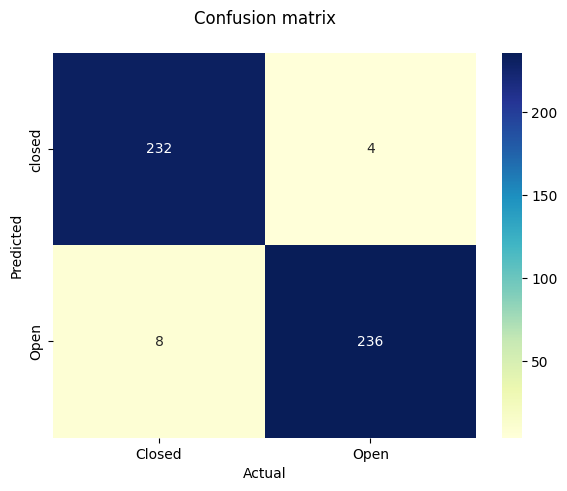

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

#Uploading the function to eye detection

In [4]:
def detector_ojo(image):
  # Loading the image
  imagen_1 = cv2.imread(image)
  #Resizing image
  nuevo_ancho = 640
  nuevo_alto = 480

  # Testing the sizes
  alto, ancho, canales = imagen_1.shape

  if alto != nuevo_alto or ancho != nuevo_ancho:
    # Update the size
      imagen_1 = cv2.resize(imagen_1, (nuevo_ancho, nuevo_alto))
  #Grayscale
  gray = cv2.cvtColor(imagen_1, cv2.COLOR_RGB2GRAY)
  #Face detection
  clasificador_rostros = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
  eyeClassif=cv2.CascadeClassifier('/content/haarcascade_eye_tree_eyeglasses.xml')
  rostros = clasificador_rostros.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
  if len(rostros) == 0:
      print("No se ha detectado ningún rostro")
  else:
    for (x, y, w, h) in rostros:
        cv2.rectangle(gray, (x, y), (x + w, y + h), (0, 0, 0), 2)
        rostro_recortado = gray[y:y + h, x:x + w].copy()
        eyes=eyeClassif.detectMultiScale(rostro_recortado)
        if len(eyes) == 0:
         print("No se ha detectado ningún ojo")
        else:
          for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(rostro_recortado,(ex,ey),(ex+ew,ey+eh),(255,0,0),3)
            ojo_recortado=rostro_recortado[ex:ex+ew,ey:ey+eh].copy()
            dimX, dimY = ojo_recortado.shape
  if len(eyes) != 0:
      img = cv2.resize(ojo_recortado,(64,64))
     # Creating kernel
      kernel = np.ones((5, 5), np.uint8)

      # Using cv2.erode() method
      image = cv2.erode(img, kernel)
      result =best_model.predict(np.expand_dims(image,0))
      return (result)
  else:
    result=0
    return(result)


#Testing the fuction

1/1 [==============================] - 0s 20ms/step


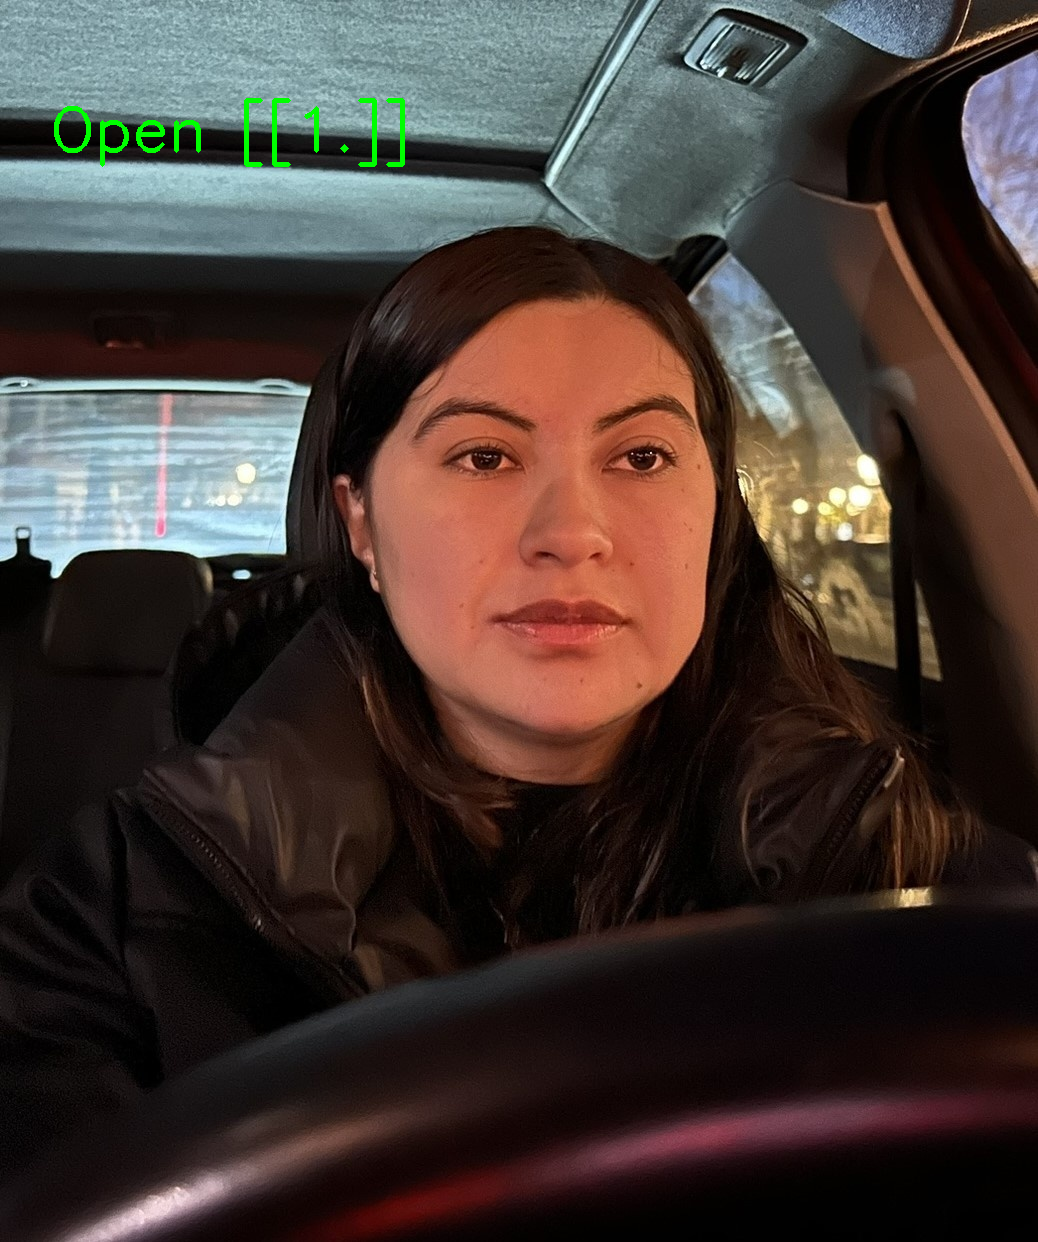

Open


In [8]:
#Loading the image to test
ruta_imagen = '/content/OPEN.JPEG' #Upload open image
imagen = cv2.imread(ruta_imagen)
ruta_png=ruta_imagen
cv2.imwrite(ruta_png, imagen, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])
imagenpng = cv2.imread(ruta_png)
result=detector_ojo(ruta_png)
if result > 0.5:
    text='Open'
else:
  text='Close'

value=result
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_thickness = 3
font_color = (0,255,0)


text_position = (50, 150)
cv2.putText(imagenpng, f"{text} {value}", text_position, font, font_scale, font_color, font_thickness)

cv2_imshow(imagenpng)
print(text)

No se ha detectado ningún ojo
No se ha detectado ningún ojo


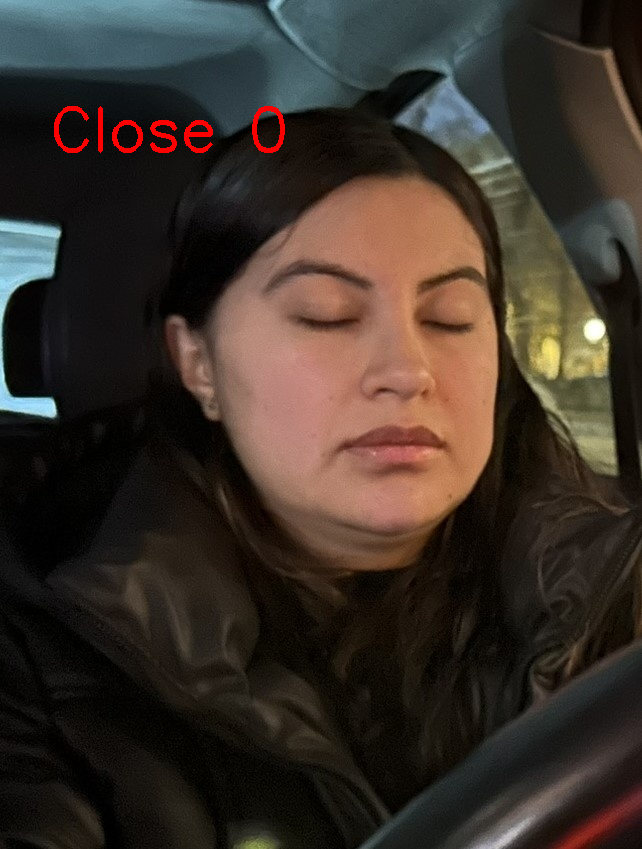

Close


In [9]:
#Loading the image to test
ruta_imagen = '/content/CLOSE.JPEG' #Upload image
imagen = cv2.imread(ruta_imagen)
ruta_png=ruta_imagen
cv2.imwrite(ruta_png, imagen, [int(cv2.IMWRITE_PNG_COMPRESSION), 0])
imagenpng = cv2.imread(ruta_png)
result=detector_ojo(ruta_png)
if result > 0.5:
    text='Open'
else:
  text='Close'

value=result
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_thickness = 3
font_color = (0, 0, 255)


text_position = (50, 150)
cv2.putText(imagenpng, f"{text} {value}", text_position, font, font_scale, font_color, font_thickness)

cv2_imshow(imagenpng)
print(text)